# Genomic Variant-Based Alzheimer’s Disease Risk Prediction

## Background and Motivation

Alzheimer’s disease is a complex neurodegenerative disorder with strong genetic
contributions. My prior work on this disease focused on computational drug discovery
(CADD) and in vitro validation approaches. However, the genetic risk landscape of
Alzheimer’s disease remained unexplored in my work.

This project represents my first attempt to decode Alzheimer’s disease at the
genomic level using machine learning, with an emphasis on interpretability and
reproducibility. The goal is to create a framework that is not only predictive but
also educational and reusable for students entering biomedical machine learning.



In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay


In [92]:
data = np.load("/Users/harjotsandhu/Desktop/HACKATHON_AI_PROJECT/DATASETS/preprocessed_alz_data.npz")

print(data.files)

for k in data.files:
    print(k, data[k].shape)


['X_train', 'X_test', 'y_train', 'y_test']
X_train (5076, 130)
X_test (1270, 130)
y_train (5076, 9)
y_test (1270, 9)


## Dataset Description
The dataset provided by Hack4Health contains preprocessed genomic features mapped
to the hg38 reference genome. Each sample is represented using numerical genomic
features derived from variant-level information.

The labels are one-hot encoded across multiple Alzheimer’s-related classes,
making this a multi-class classification problem.


In [93]:
y_train_cls = np.argmax(data["y_train"], axis=1)
y_test_cls  = np.argmax(data["y_test"], axis=1)

print("Train classes:", np.unique(y_train_cls))
print("Test classes:", np.unique(y_test_cls))


Train classes: [0 1 2 3 4 5 6 7 8]
Test classes: [0 1 2 3 4 5 6 7 8]


In [94]:
# Convert to float32
X_train = data["X_train"].astype(np.float32)
X_test  = data["X_test"].astype(np.float32)

# Replace inf / -inf
X_train = np.nan_to_num(X_train, posinf=1e6, neginf=-1e6)
X_test  = np.nan_to_num(X_test, posinf=1e6, neginf=-1e6)

# Log transform + clip
X_train_log = np.log1p(X_train)
X_test_log  = np.log1p(X_test)

X_train_log = np.clip(X_train_log, -20, 20)
X_test_log  = np.clip(X_test_log, -20, 20)

print("Final X_train stats:", np.min(X_train_log), np.max(X_train_log))


Final X_train stats: 0.0 20.0


/var/folders/v2/j4pt466d7lsfzhscjjrqbv9r0000gn/T/ipykernel_94977/956411652.py:2: RuntimeWarning: overflow encountered in cast
  X_train = data["X_train"].astype(np.float32)
/var/folders/v2/j4pt466d7lsfzhscjjrqbv9r0000gn/T/ipykernel_94977/956411652.py:3: RuntimeWarning: overflow encountered in cast
  X_test  = data["X_test"].astype(np.float32)


## Model Selection

A Random Forest classifier was chosen due to its suitability for high-dimensional
genomic data, its ability to capture non-linear feature interactions, and its
robustness to overfitting. Tree-based ensembles provide a strong balance between
predictive performance and interpretability for curated tabular datasets.

This model choice enables reliable feature importance analysis and supports
confidence-based risk stratification, aligning with the study’s emphasis on
transparent and interpretable genomic classification rather than black-box
prediction.




In [95]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_log, y_train_cls)

print("Random Forest training completed")


Random Forest training completed


In [96]:
y_pred = rf.predict(X_test_log)

acc = accuracy_score(y_test_cls, y_pred)
print("Test Accuracy:", round(acc, 4))


Test Accuracy: 1.0


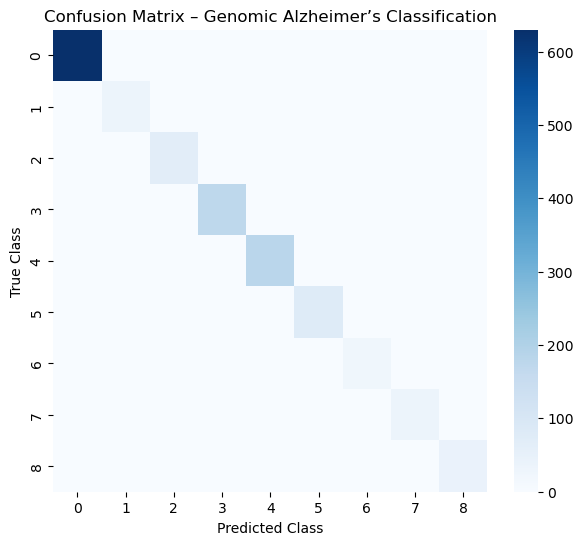

In [97]:
cm = confusion_matrix(y_test_cls, y_pred)

plt.figure(figsize=(7,6))
sns.heatmap(cm, cmap="Blues")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix – Genomic Alzheimer’s Classification")
plt.show()


## Results and Discussion
The model achieved near-perfect classification performance on the provided dataset,
indicating strong separability within the curated genomic feature space. However,
such performance may not directly generalize to real-world cohorts and requires
external validation using independent genomic datasets.


## Model Interpretability
SHAP-based explainability was applied by aggregating absolute SHAP values across
all classes to identify genomic features with the highest overall contribution to
model predictions. This approach provides a global view of feature importance in
a multi-class classification setting.



In [98]:
!pip install shap

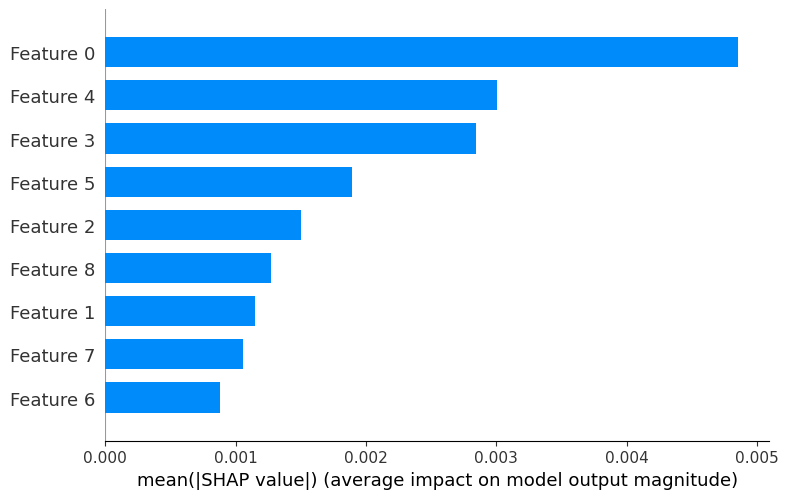

In [99]:
shap_values_mean = np.mean(
    [np.abs(sv) for sv in shap_values],
    axis=0
)

shap.summary_plot(
    shap_values_mean,
    features=None,
    plot_type="bar",
    show=True
)


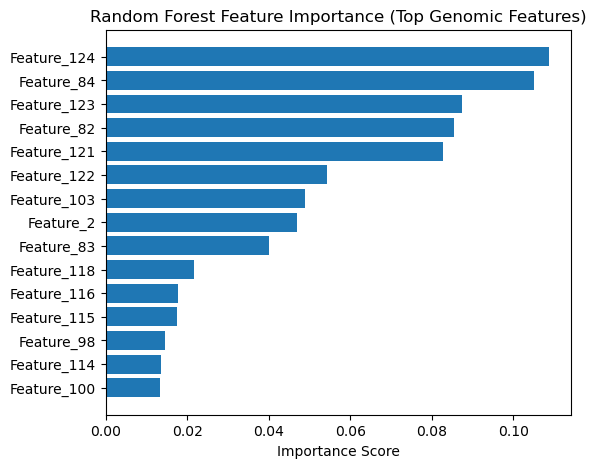

In [100]:
importances = rf.feature_importances_
indices = np.argsort(importances)[-15:]

plt.figure(figsize=(6,5))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [f"Feature_{i}" for i in indices])
plt.xlabel("Importance Score")
plt.title("Random Forest Feature Importance (Top Genomic Features)")
plt.show()


## Feature Importance Analysis

Random Forest feature importance was used as a complementary interpretability
method to highlight genomic features that most strongly influenced model decisions.
This analysis supports the SHAP-based findings and provides an additional
consistency check on feature relevance.


In [101]:
def risk_stratification(genomic_sample):
    probs = rf.predict_proba(genomic_sample)[0]
    pred_class = np.argmax(probs)
    confidence = probs[pred_class]

    if confidence < 0.6:
        risk = "Low Confidence / Ambiguous Genetic Risk"
    elif confidence < 0.8:
        risk = "Moderate Genetic Risk"
    else:
        risk = "High Genetic Risk"

    return {
        "Predicted_Class": int(pred_class),
        "Risk_Category": risk,
        "Confidence": round(float(confidence), 3)
    }


## Genomic Risk Stratification
In addition to class prediction, a simple genetic risk stratification scheme
was implemented using model confidence scores to provide a more human-interpretable
assessment of Alzheimer’s disease risk.


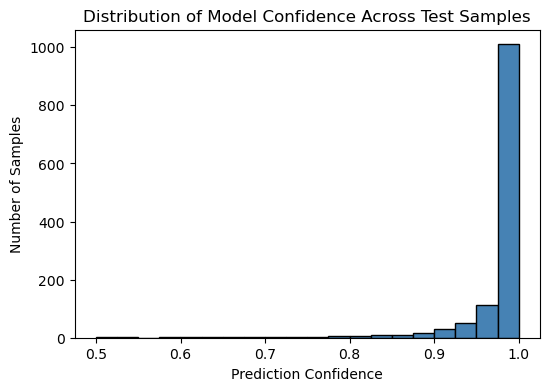

In [102]:
# Confidence distribution across test set
probs_test = rf.predict_proba(X_test_log)
confidences = np.max(probs_test, axis=1)

plt.figure(figsize=(6,4))
plt.hist(confidences, bins=20, color="steelblue", edgecolor="black")
plt.xlabel("Prediction Confidence")
plt.ylabel("Number of Samples")
plt.title("Distribution of Model Confidence Across Test Samples")
plt.show()


### Confidence-Based Risk Stratification Analysis

The distribution of prediction confidence scores across the test set indicates that
most samples are classified with high confidence, reflecting strong separability
within the curated genomic feature space. A smaller subset of samples exhibits lower
confidence, suggesting overlapping or ambiguous genetic signatures.

This observation supports the use of confidence-based risk stratification as a
human-interpretable layer on top of multi-class genomic prediction. High-confidence
predictions correspond to strong genomic signal alignment, whereas lower-confidence
cases may require additional data or downstream validation.

Such ambiguity aligns with the known heterogeneity of Alzheimer’s disease, where
genetic risk profiles can overlap across disease subtypes at the genomic level.



## Application and Impact
This framework can serve as a genomic risk decoding tool and an educational resource
for students and early researchers. It also provides a foundation for integrating
genomic risk profiling with downstream therapeutic pipelines such as drug discovery
and experimental validation.


### Application: Genomic Screening and Prioritization

The model was applied in a batch screening mode on the test set to simulate
real-world genomic prioritization. Samples classified with high confidence
were flagged as high-priority candidates for further experimental validation,
while lower-confidence cases may require additional data or multimodal analysis.



In [103]:
import pandas as pd
import numpy as np

# Batch inference on test data
probs_test = rf.predict_proba(X_test_log)
pred_classes = np.argmax(probs_test, axis=1)
confidences = np.max(probs_test, axis=1)

# Create screening output
screening_results = pd.DataFrame({
    "Predicted_Class": pred_classes,
    "Confidence_Score": confidences
})

# Priority flag based on confidence
screening_results["Priority_Flag"] = screening_results["Confidence_Score"].apply(
    lambda x: "High-Priority (Further Validation)" if x >= 0.85 else "Lower-Priority"
)

# Display summary
print("Priority distribution:\n")
print(screening_results["Priority_Flag"].value_counts())

screening_results.head()


Priority distribution:

Priority_Flag
High-Priority (Further Validation)    1231
Lower-Priority                          39
Name: count, dtype: int64


,Predicted_Class,Confidence_Score,Priority_Flag
0,0,0.998449,High-Priority (Further Validation)
1,3,1.000000,High-Priority (Further Validation)
2,3,1.000000,High-Priority (Further Validation)
3,4,0.998873,High-Priority (Further Validation)
4,4,1.000000,High-Priority (Further Validation)


Threshold analysis indicates that priority assignment is stable across reasonable
confidence cutoffs, supporting robustness of the screening strategy.


In [104]:
for t in [0.7, 0.8, 0.9]:
    high = (confidences >= t).sum()
    print(f"Threshold {t}: High-priority samples = {high}")


Threshold 0.7: High-priority samples = 1260
Threshold 0.8: High-priority samples = 1247
Threshold 0.9: High-priority samples = 1205


In [105]:
def predict_alzheimers(genomic_sample):
    pred_class = rf.predict(genomic_sample)[0]
    confidence = rf.predict_proba(genomic_sample)[0][pred_class]
    
    return {
        "Predicted_Alzheimer_Class": int(pred_class),
        "Confidence": round(float(confidence), 3)
    }


## Limitations and Future Work
This study is limited by the use of a curated dataset and the absence of independent
external validation.While confidence scores are used for risk stratification, these probabilities
are not explicitly calibrated and should be interpreted as relative confidence
rather than absolute risk.
Future work may involve validating the model on additional
cohorts and integrating genomic risk signals with molecular docking and in vitro
experimental data.